# Jailbreaking Deep Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import json
import os
import copy


## Task 1: Basics

In [2]:
# Download ResNet34
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 136MB/s]


In [5]:
!unzip TestDataSet.zip

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
  inflating: __MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/n02769748/
  inflating: __MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/n02834397/
  inflating: __MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/n02917067/
  inflating: __MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/n02808304/
  inflating: __MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/n03016953/
  inflating: __MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/n02793495/
  inflating: __MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/n02814533/
  inflating: __MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/n02837789/
  inflating: __MACOSX/TestDataSet/._n02837789  
   creating: TestDataSet/n02840245/
  inflating: __MACOSX/TestDataSet/._n02840245  
   creating: TestDataSet/n02992211/
  inflating: __MACOSX/TestDataSet/._n02992211  
   creating: TestDataSet

In [6]:
# Load label index mapping
with open('TestDataSet/labels_list.json', 'r') as f:
    label_entries = json.load(f)

# Convert to a mapping from class name to ImageNet index
class_to_imagenet_idx = {}
imagenet_indices = [int(entry.split(":")[0]) for entry in label_entries]

# Extract folder names
folder_names = [d for d in os.listdir("TestDataSet") if os.path.isdir(os.path.join("TestDataSet", d)) and d.startswith("n")]

# Map folder names in order to the corresponding label index
class_to_imagenet_idx = dict(zip(sorted(folder_names), imagenet_indices))


# class_to_imagenet_idx

In [7]:
# Test data processing
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=plain_transforms)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Evaluate the pre-trained model on this test dataset
pretrained_model.eval()
pretrained_model.cuda()

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.cuda()
        outputs = pretrained_model(inputs)

        # Get top-5 predictions
        _, pred_top5 = outputs.topk(5, dim=1)

        # Match against original ImageNet class indices
        gt_labels = [class_to_imagenet_idx[dataset.classes[label]] for label in labels]
        gt_labels = torch.tensor(gt_labels).to(inputs.device)

        # Top-1 accuracy
        top1_preds = pred_top5[:, 0]
        top1_correct += (top1_preds == gt_labels).sum().item()

        # Top-5 accuracy
        match_array = pred_top5.eq(gt_labels.unsqueeze(1))
        top5_correct += match_array.sum().item()

        total += labels.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


## Task2: Pixel-wise attacks

In [11]:
# Compute normalized pixel value range for clamping
normalized_min = (0 - mean_norms) / std_norms
normalized_max = (1 - mean_norms) / std_norms
normalized_min_tensor = torch.tensor(normalized_min).view(3, 1, 1).to(torch.float32).cuda()
normalized_max_tensor = torch.tensor(normalized_max).view(3, 1, 1).to(torch.float32).cuda()

def fgsm_attack(image, epsilon, gradient):
    sign_data_grad = gradient.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.max(torch.min(perturbed_image, normalized_max_tensor), normalized_min_tensor)

# Store min/max trackers
orig_pixel_min, orig_pixel_max = [], []
adv_pixel_min, adv_pixel_max = [], []

# Apply FGSM
adversarial_examples = []
original_examples = []
adv_labels = []
original_labels = []

epsilon = 0.02
loss_fn = nn.CrossEntropyLoss()
pretrained_model.eval()

for inputs, labels in dataloader:
    inputs = inputs.cuda()
    labels = labels.cuda()

    inputs.requires_grad = True
    outputs = pretrained_model(inputs)

    gt_labels = [class_to_imagenet_idx[dataset.classes[label]] for label in labels]
    gt_labels = torch.tensor(gt_labels).to(inputs.device)

    loss = loss_fn(outputs, gt_labels)
    pretrained_model.zero_grad()
    loss.backward()

    data_grad = inputs.grad.data
    perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

    adversarial_examples.append(perturbed_data.detach().cpu())
    original_examples.append(inputs.detach().cpu())
    adv_labels.extend(gt_labels.cpu().numpy())
    original_labels.extend(gt_labels.cpu().numpy())

    # Track pixel value range
    orig_pixel_min.append(inputs.min().item())
    orig_pixel_max.append(inputs.max().item())
    adv_pixel_min.append(perturbed_data.min().item())
    adv_pixel_max.append(perturbed_data.max().item())

# Output pixel value ranges
print(f"Original normalized pixel range: [{min(orig_pixel_min):.4f}, {max(orig_pixel_max):.4f}]")
print(f"Adversarial normalized pixel range: [{min(adv_pixel_min):.4f}, {max(adv_pixel_max):.4f}]")

# Save adversarial dataset
adv_images = torch.cat(adversarial_examples)
torch.save(adv_images, "Adversarial_Test_Set_1.pt")
print("Saved adversarial dataset as Adversarial_Test_Set_1.pt")

Original normalized pixel range: [-2.1179, 2.6400]
Adversarial normalized pixel range: [-2.1179, 2.6400]
Saved adversarial dataset as Adversarial_Test_Set_1.pt


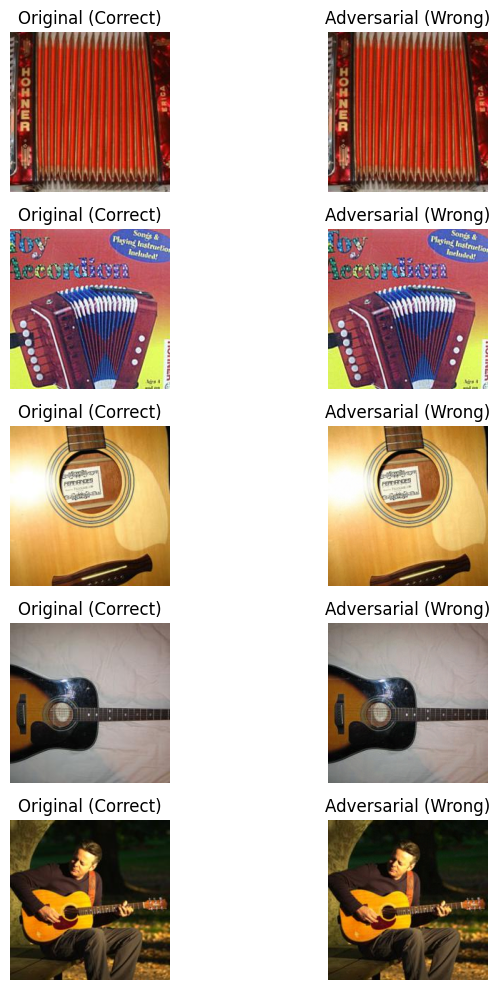

In [13]:
shown = 0
max_to_show = 5
fig, axs = plt.subplots(max_to_show, 2, figsize=(8, 2 * max_to_show))

# Define inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=(-mean_norms / std_norms).tolist(),
    std=(1.0 / std_norms).tolist()
)

with torch.no_grad():
    # Flatten the batched tensors and labels
    orig_all = torch.cat(original_examples)
    adv_all = torch.cat(adversarial_examples)
    labels_all = torch.tensor(original_labels)

    for i in range(len(orig_all)):
        if shown >= max_to_show:
            break

        orig_img = orig_all[i].unsqueeze(0).cuda()
        adv_img = adv_all[i].unsqueeze(0).cuda()
        label = labels_all[i].unsqueeze(0).cuda()

        orig_pred = pretrained_model(orig_img).argmax(dim=1)
        adv_pred = pretrained_model(adv_img).argmax(dim=1)

        if orig_pred.item() == label.item() and adv_pred.item() != label.item():
            orig_vis = inv_normalize(orig_img.squeeze().cpu()).permute(1, 2, 0).numpy()
            adv_vis = inv_normalize(adv_img.squeeze().cpu()).permute(1, 2, 0).numpy()

            axs[shown, 0].imshow(np.clip(orig_vis, 0, 1))
            axs[shown, 0].set_title("Original (Correct)")
            axs[shown, 0].axis("off")

            axs[shown, 1].imshow(np.clip(adv_vis, 0, 1))
            axs[shown, 1].set_title("Adversarial (Wrong)")
            axs[shown, 1].axis("off")

            shown += 1

plt.tight_layout()
plt.show()

In [14]:
# Evaluate model on adversarial examples
adv_dataset = torch.utils.data.TensorDataset(adv_images, torch.tensor(adv_labels))
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False, num_workers=4)

adv_top1_correct = 0
adv_top5_correct = 0
adv_total = 0

with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = pretrained_model(inputs)

        _, pred_top5 = outputs.topk(5, dim=1)

        adv_top1_correct += (pred_top5[:, 0] == labels).sum().item()
        adv_top5_correct += pred_top5.eq(labels.unsqueeze(1)).sum().item()
        adv_total += labels.size(0)

adv_top1_acc = adv_top1_correct / adv_total * 100
adv_top5_acc = adv_top5_correct / adv_total * 100
print(f"[Adversarial FGSM] Top-1 Accuracy: {adv_top1_acc:.2f}%")
print(f"[Adversarial FGSM] Top-5 Accuracy: {adv_top5_acc:.2f}%")

[Adversarial FGSM] Top-1 Accuracy: 6.20%
[Adversarial FGSM] Top-5 Accuracy: 35.40%
